# RNA velocity with scvelo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scvelo as scv

RNA velocity is a method for estimating the rate of change in gene expression in scRNA-seq dataset. Differently from pseudotime trajectory inference, where you need to specify a "root" cell, RNA velocity tells you the direction along which cells are evolving in gene expression space. RNA velocity achieves this by examining the ratio of unspliced (intronic-containing) and spliced (exonic-only) reads in a dataset.

In the previous notebook, we walked through the theoretical foundations behind RNA velocity. Here, we will demonstrate how to practically apply it to a dataset using the scvelo package, which is nicely integrated with the scanpy framework we have been working with during the past two days. This exercise is partially adapted from several tutorials on the scvelo documentation page: https://scvelo.readthedocs.io/

First, we will load a dataset on pancreatic endocrinogenesis

In [2]:
adata = scv.datasets.pancreas()
adata

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

**Exercise 1**: As we can see from the metadata, this dataset already contains a low dimensional UMAP embedding with cluster annotations. Can you plot this UMAP embedding, coloring the cells by `clusters`?

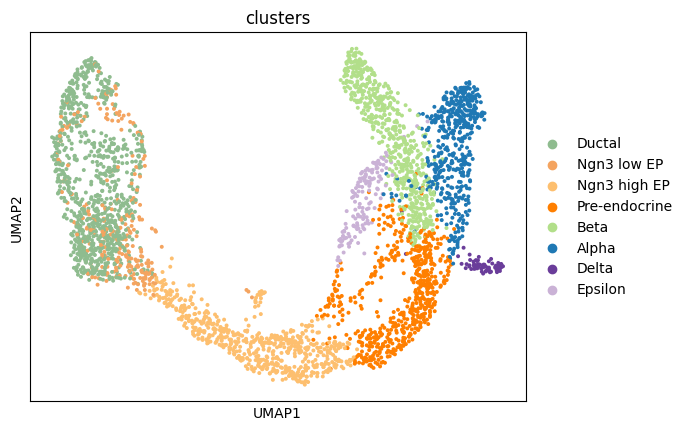

In [3]:
sc.pl.umap(adata, color='clusters')

Next, we display the proportions of spliced/unspliced counts. Depending on the protocol used , we typically have between 10%-25% of unspliced molecules containing intronic sequences. For single-nuclei data, you will have many more intronic reads, approximately 60%-70%. We also advice you to examine the variations on cluster level to verify consistency in splicing efficiency. Here, we find variations as expected, with slightly lower unspliced proportions at cycling ductal cells, then higher proportion at cell fate commitment in Ngn3-high and Pre-endocrine cells where many genes start to be transcribed.

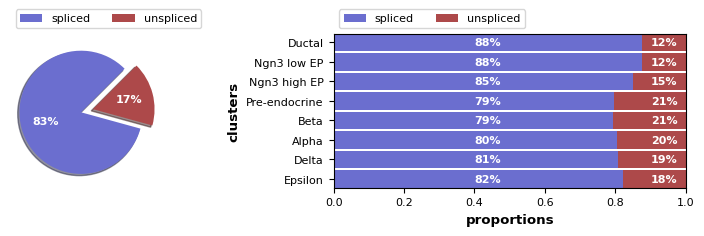

In [4]:
scv.pl.proportions(adata, groupby="clusters")

Next, as with our standard scRNA-seq analysis pipeline, we need to preprocess the data! This requires performing the following steps, which you have studied in previous exercises:
- Gene filtering (with a minimum number of counts per cell)
- Normalization
- Log transformation

In scvelo, these steps are combined into a single function, called `scv.pp.filter_and_normalize`. We will run that command below with two parameters specified:
- `min_shared_counts` requires a minimum number of counts (both spliced and unspliced) for all genes; any other genes are filtered out
- `n_top_genes` is similar to `sc.pp.highly_variable_genes` from scanpy, finding the top variable genes and filtering out the others

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


**Exercise 2**: As we mentioned, `scv.pp.filter_and_normalize` combines several scanpy functions into a single command. However, if you want full control over the filtering, normalization, and log-transformation steps, you can run each command individually. Can you write the five lines of code needed to achieve the above steps?

**Answer**

Next, we need to compute a PCA and neighborhood graph, as we have done previously.

**Exercise 3**: Write the commands to compute the PCA and then the neighborhood graph (using `n_pcs=30` and `n_neighbors=30`)

In [6]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

Next, we need to compute the first and second order moments (means and uncentered variances) computed among nearest neighbors in PCA space, summarized in `scv.pp.moments`.

In [7]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Velocities are vectors in gene expression space and represent the direction and speed of movement of the individual cells. The velocities are obtained by modeling transcriptional dynamics of splicing kinetics, either stochastically (default) or deterministically (by setting mode='deterministic'). For each gene, a steady-state-ratio of pre-mature (unspliced) and mature (spliced) mRNA counts is fitted, which constitutes a constant transcriptional state. Velocities are then obtained as residuals from this ratio. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

In [8]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


The combination of velocities across genes can then be used to estimate the future state of an individual cell. In order to project the velocities into a lower-dimensional embedding, transition probabilities of cell-to-cell transitions are estimated. That is, for each velocity vector we find the likely cell transitions that are accordance with that direction. The transition probabilities are computed using cosine correlation between the potential cell-to-cell transitions and the velocity vector, and are stored in a matrix denoted as velocity graph. The resulting velocity graph has dimension 𝑛𝑜𝑏𝑠×𝑛𝑜𝑏𝑠
 and summarizes the possible cell state changes that are well explained through the velocity vectors (for runtime speedup it can also be computed on reduced PCA space by setting approx=True).

In [9]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/160 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Finally, the velocities are projected onto any embedding, specified by basis, and visualized in one of these ways: - on cellular level with scv.pl.velocity_embedding, - as gridlines with scv.pl.velocity_embedding_grid, - or as streamlines with scv.pl.velocity_embedding_stream.

Note, that the data has an already pre-computed UMAP embedding, and annotated clusters. When applying to your own data, these can be obtained with scv.tl.umap and scv.tl.louvain.

The most fine-grained resolution of the velocity vector field we get at single-cell level, with each arrow showing the direction and speed of movement of an individual cell. That reveals, e.g., the early endocrine commitment of Ngn3-cells (yellow) and a clear-cut difference between near-terminal α-cells (blue) and transient β-cells (green).

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


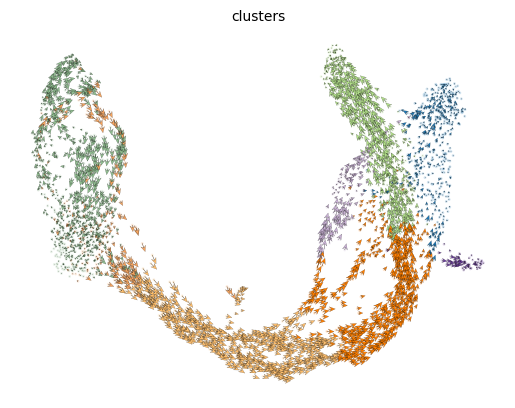

In [10]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, color='clusters')

The velocity vector field displayed as streamlines yields fine-grained insights into the developmental processes. It accurately delineates the cycling population of ductal cells and endocrine progenitors. Further, it illuminates cell states of lineage commitment, cell-cycle exit, and endocrine cell differentiation.

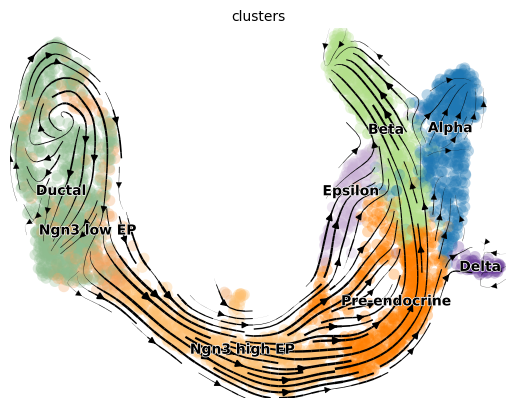

In [11]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='clusters')

This is perhaps the most important part as we advise the user not to limit biological conclusions to the projected velocities, but to examine individual gene dynamics via phase portraits to understand how inferred directions are supported by particular genes.

**As we discussed in our previous exercise into the theoretical foundations of RNA velocity**: Gene activity is orchestrated by transcriptional regulation. Transcriptional induction for a particular gene results in an increase of (newly transcribed) precursor unspliced mRNAs while, conversely, repression or absence of transcription results in a decrease of unspliced mRNAs. Spliced mRNAs is produced from unspliced mRNA and follows the same trend with a time lag. Time is a hidden/latent variable. Thus, the dynamics needs to be inferred from what is actually measured: spliced and unspliced mRNAs as displayed in the phase portrait. 

Now, let us examine the phase portraits of some marker genes, visualized with scv.pl.velocity(adata, gene_names) or scv.pl.scatter(adata, gene_names).

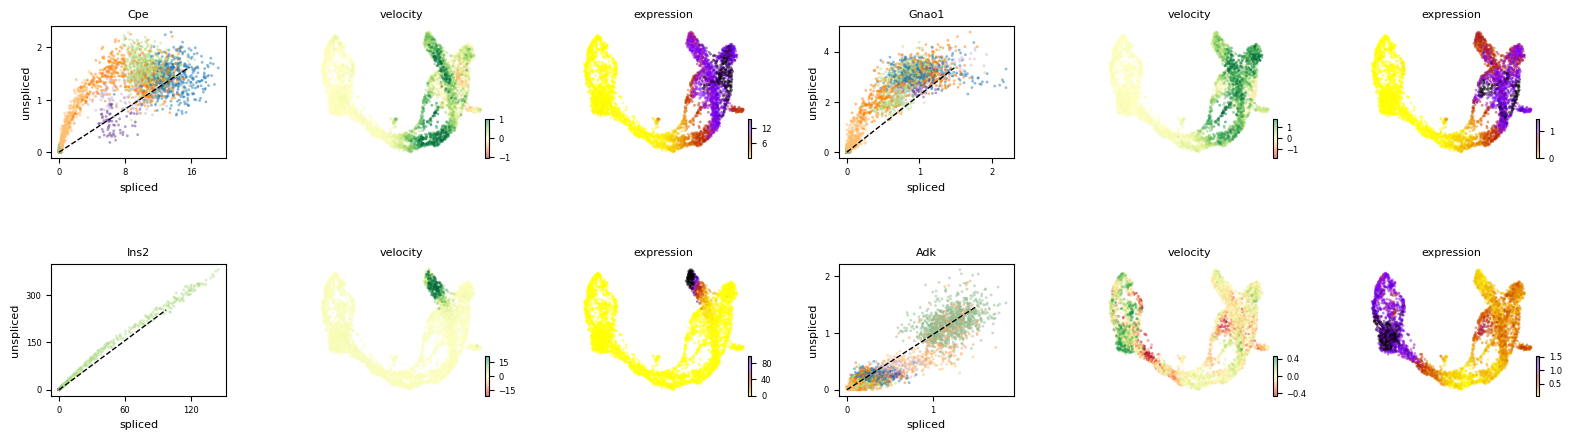

In [12]:
scv.pl.velocity(adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

**Exercise 4**: Describe the plots above: what can you tell me about the patterns of the four genes, Cpe, Gnao1, Ins2, Adk, along the differentiation trajectory. Transitioning from ductal cells to mature alpha and beta cells, which genes are being upregulated? Which genes are being downregulated along the same trajectory? Are any of the genes limited to a particular cell type or lineage?

**Answer**: Cpe explains the directionality in the up-regulated Ngn3 (yellow) to Pre-endocrine (orange) to β-cells (green), while Adk explains the directionality in the down-regulated Ductal (dark green) to Ngn3 (yellow) to the remaining endocrine cells.

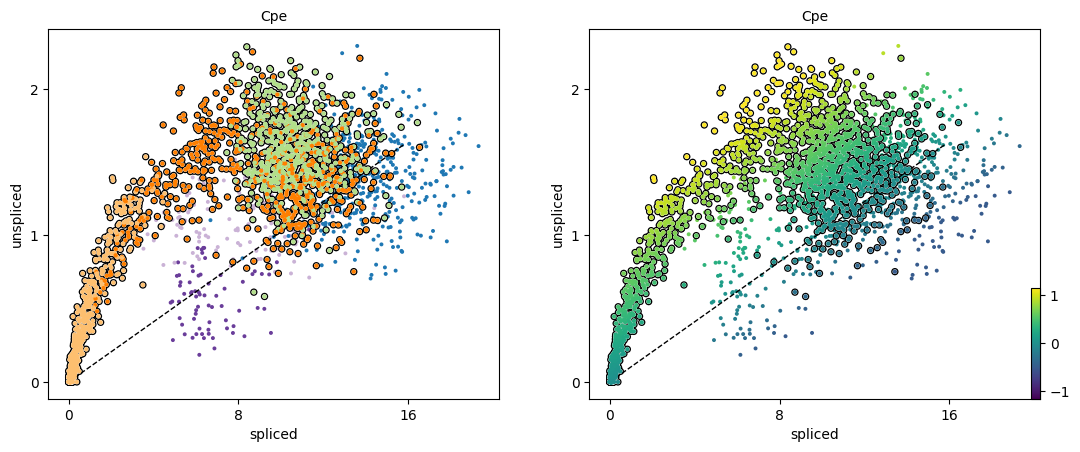

In [13]:
scv.pl.scatter(adata, 'Cpe', color=['clusters', 'velocity'],
               add_outline='Ngn3 high EP, Pre-endocrine, Beta')

**Exercise 5**: What does the black dashed line represent in the phase portrait plots, and how does this relate to the way in which RNA velocity is determined?

**Answer**: The black line corresponds to the estimated ‘steady-state’ ratio, i.e. the ratio of unspliced to spliced mRNA abundance which is in a constant transcriptional state. RNA velocity for a particular gene is determined as the residual, i.e. how much an observation deviates from that steady-state line. 

We need a systematic way to identify genes that may help explain the resulting vector field and inferred lineages. To do so, we can test which genes have cluster-specific differential velocity expression, being siginificantly higher/lower compared to the remaining population. The module scv.tl.rank_velocity_genes runs a differential velocity t-test and outpus a gene ranking for each cluster. Thresholds can be set (e.g. min_corr) to restrict the test on a selection of gene candidates.

In [14]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)

df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:03) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine    Beta    Alpha    Delta  \
0  Notch2       Ptpn3        Pde1c        Baiap3    Pax6  Zcchc16    Zdbf2   
1    Sox5       Hspa8         Pclo           Pam   Unc5c    Nell1    Ptprt   
2   Hspa8      Dcbld1        Ptprs          Sdk1    Nnat     Ksr2  Akr1c19   
3   Krt19       Grb10     Rap1gap2         Abcc8  Kcnmb2   Prune2     Ank2   
4   Nr2f6       Hacd1        Kcnb2        Ptprn2    Scg3    Ndst4   Spock3   

  Epsilon  
0    Heg1  
1    Ica1  
2   Tmcc3  
3  Gpr179  
4  Mamld1

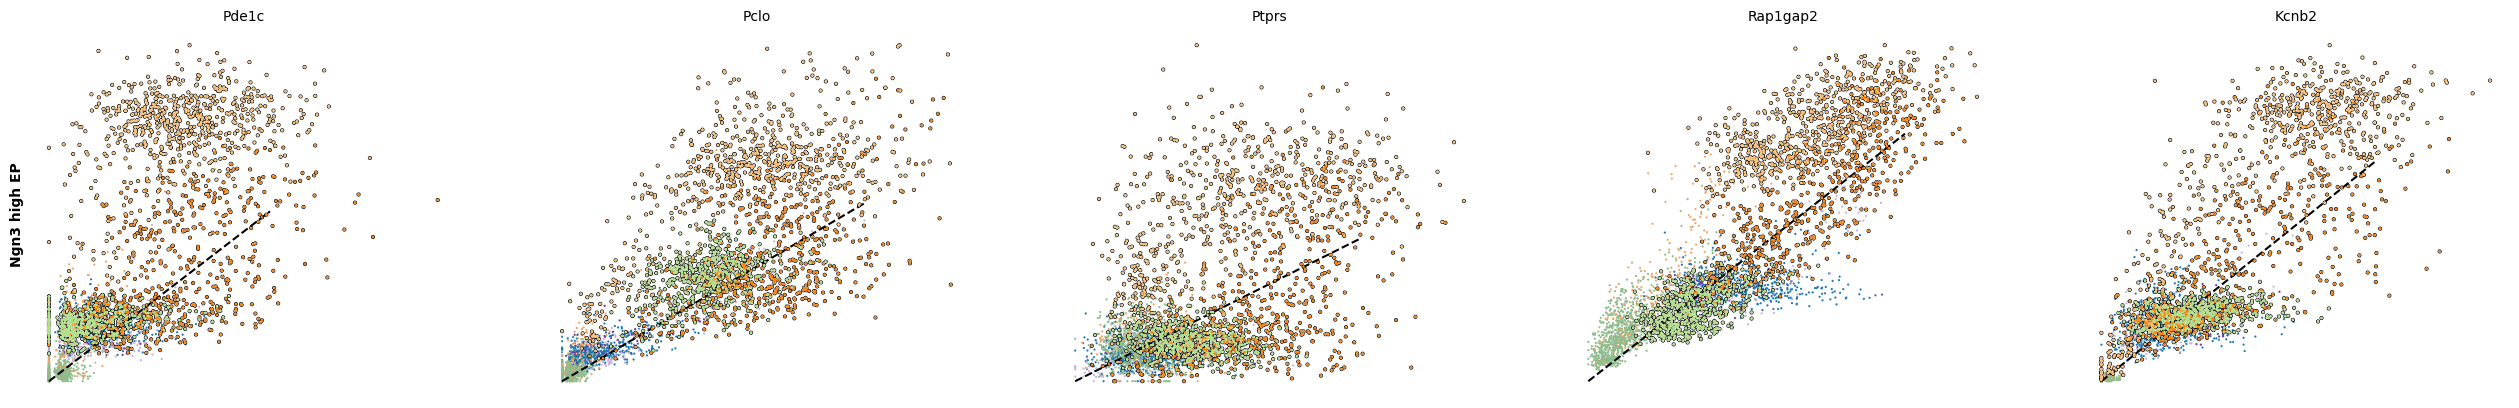

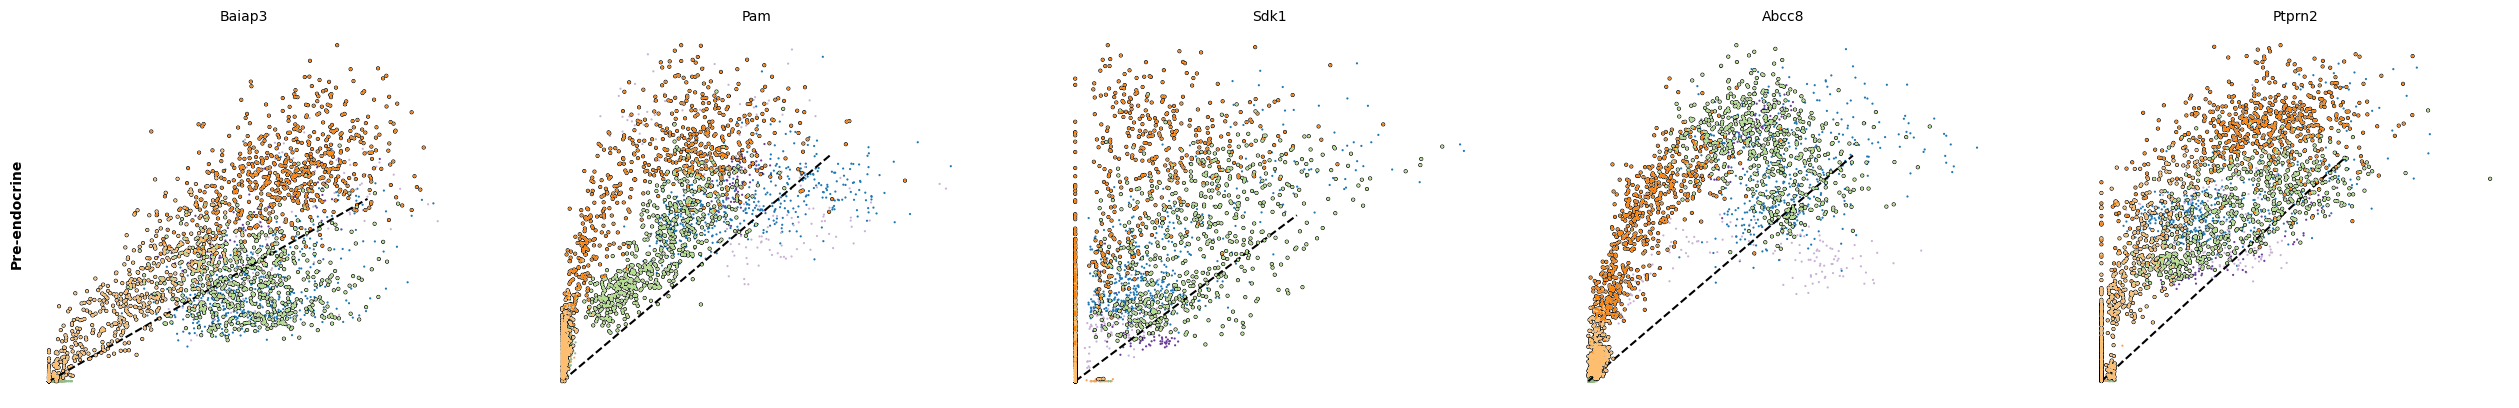

In [15]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='Ngn3 high EP, Pre-endocrine, Beta')

scv.pl.scatter(adata, df['Ngn3 high EP'][:5], ylabel='Ngn3 high EP', **kwargs)
scv.pl.scatter(adata, df['Pre-endocrine'][:5], ylabel='Pre-endocrine', **kwargs)

The genes Ptprs, Pclo, Pam, Abcc8, Gnas, for instance, support the directionality from Ngn3 high EP (yellow) to Pre-endocrine (orange) to Beta (green).

## Dynamical modeling of RNA velocity

Since RNA velocity yields insights into the directionality of gene expression change, we can use the approach to infer a trajectory. One way this is acheives is by recovering estimates of the full transcriptional dynamics (i.e., the transcription rate, the splicing rate, and the degradation rate) instead of using the steady-state asusmption and linear fits. This is particularly useful when you have a dataset without a cluster of cells representing the "steady-state". 

Dynamical modeling of RNA velocity is possible with scvelo and allows for:
- Estimation of a latent time
- Identification of possible driver genes

We run the dynamical model to learn the full transcriptional dynamics of splicing kinetics.

It is solved in a likelihood-based expectation-maximization framework, by iteratively estimating the parameters of reaction rates and latent cell-specific variables, i.e. transcriptional state and cell-internal latent time. It thereby aims to learn the unspliced/spliced phase trajectory for each gene.

In [16]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/160 cores)


  0%|          | 0/1036 [00:00<?, ?gene/s]

    finished (0:06:26) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Then, we before we need to estiamte the velocity and compute the velocity graph, specifying this time the "dynamical" mode.

In [17]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:06) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/160 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Running the dynamical model can take a while (up to 10 mins for this dataset)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


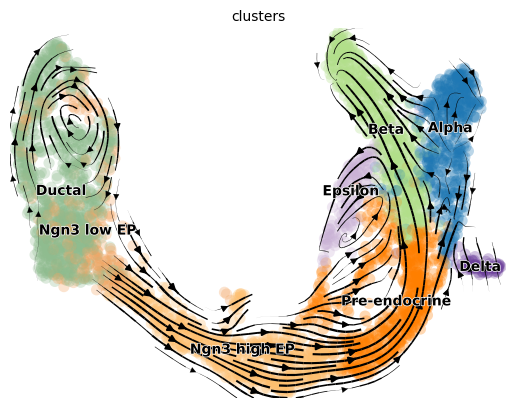

In [18]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

The rates of RNA transcription, splicing and degradation are estimated without the need of any experimental data.

They can be useful to better understand the cell identity and phenotypic heterogeneity.

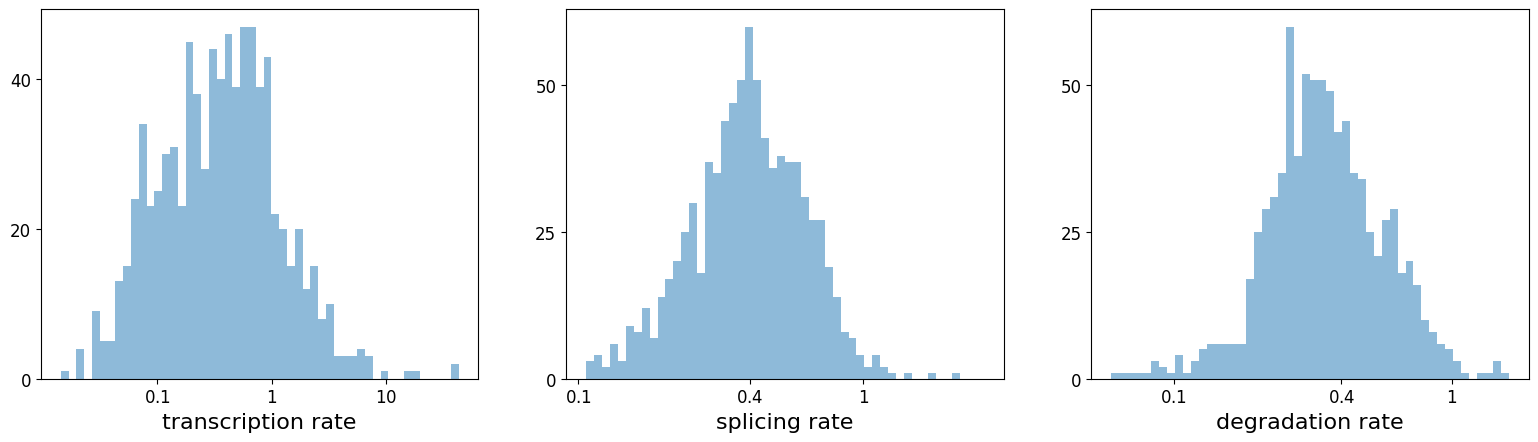

fit_alpha   fit_beta  fit_gamma     fit_t_  fit_scaling  fit_std_u  \
index                                                                         
Sntg1     0.011041   0.004043   0.080231  25.527206    52.120241   1.021111   
Sbspon    0.225797   1.682173   0.302747   6.147519     0.463775   0.057540   
Mcm3      4.098365  59.257791   1.203317   1.986274     0.012154   0.015394   
Fam135a   0.169396   0.113233   0.185499  11.025427     1.057786   0.350119   
Adgrb3    0.039118   0.007863   0.195750   7.880056   118.323538   2.063335   

         fit_std_s  fit_likelihood  fit_u0  fit_s0  fit_pval_steady  \
index                                                                 
Sntg1     0.023619        0.367464     0.0     0.0         0.008509   
Sbspon    0.175868        0.242276     0.0     0.0         0.215998   
Mcm3      0.687152        0.125647     0.0     0.0         0.480542   
Fam135a   0.153911        0.271898     0.0     0.0         0.414863   
Adgrb3    0.028773        0.362395     0.0     0.0         0.072837   

         fit_steady_u  fit_steady_s  fit_variance  fit_alignment_scaling  \
index                                                                      
Sntg1        2.507244      0.075472      0.259419               6.120456   
Sbspon       0.162373      0.481733      0.794976               1.816960   
Mcm3         0.060191      1.991981      0.985103               0.717393   
Fam135a      1.239550      0.397954      0.730658               3.569145   
Adgrb3       4.881226      0.095819      0.380088               1.773425   

           fit_r2  
index              
Sntg1    0.466323  
Sbspon   0.651425  
Mcm3     0.282687  
Fam135a  0.362124  
Adgrb3   0.376199

In [19]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics. This offers advantages over traditional pseudotime trajectory inference approaches.

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


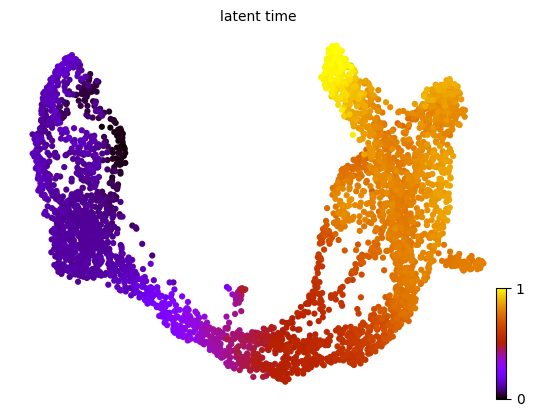

In [20]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

Driver genes display pronounced dynamic behavior and are systematically detected via their characterization by high likelihoods in the dynamic model. We can plot a heatmap of the top 300 genes expressed along the pseudotime.

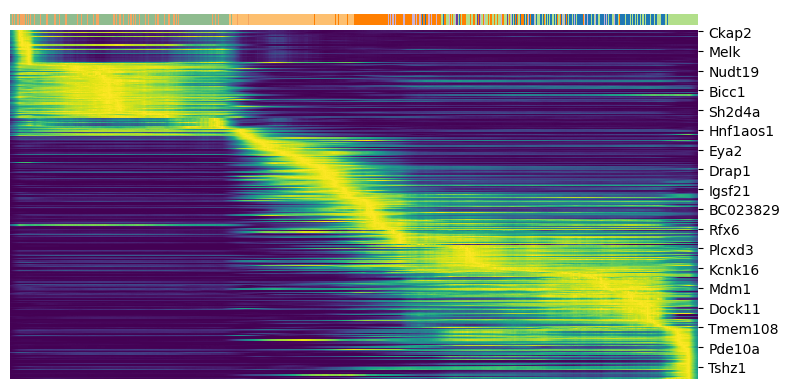

In [21]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

For any top candidates that you might want to validate biologically, it is always essential to examine the phase portraits, to ensure that the gene is not too noisy.

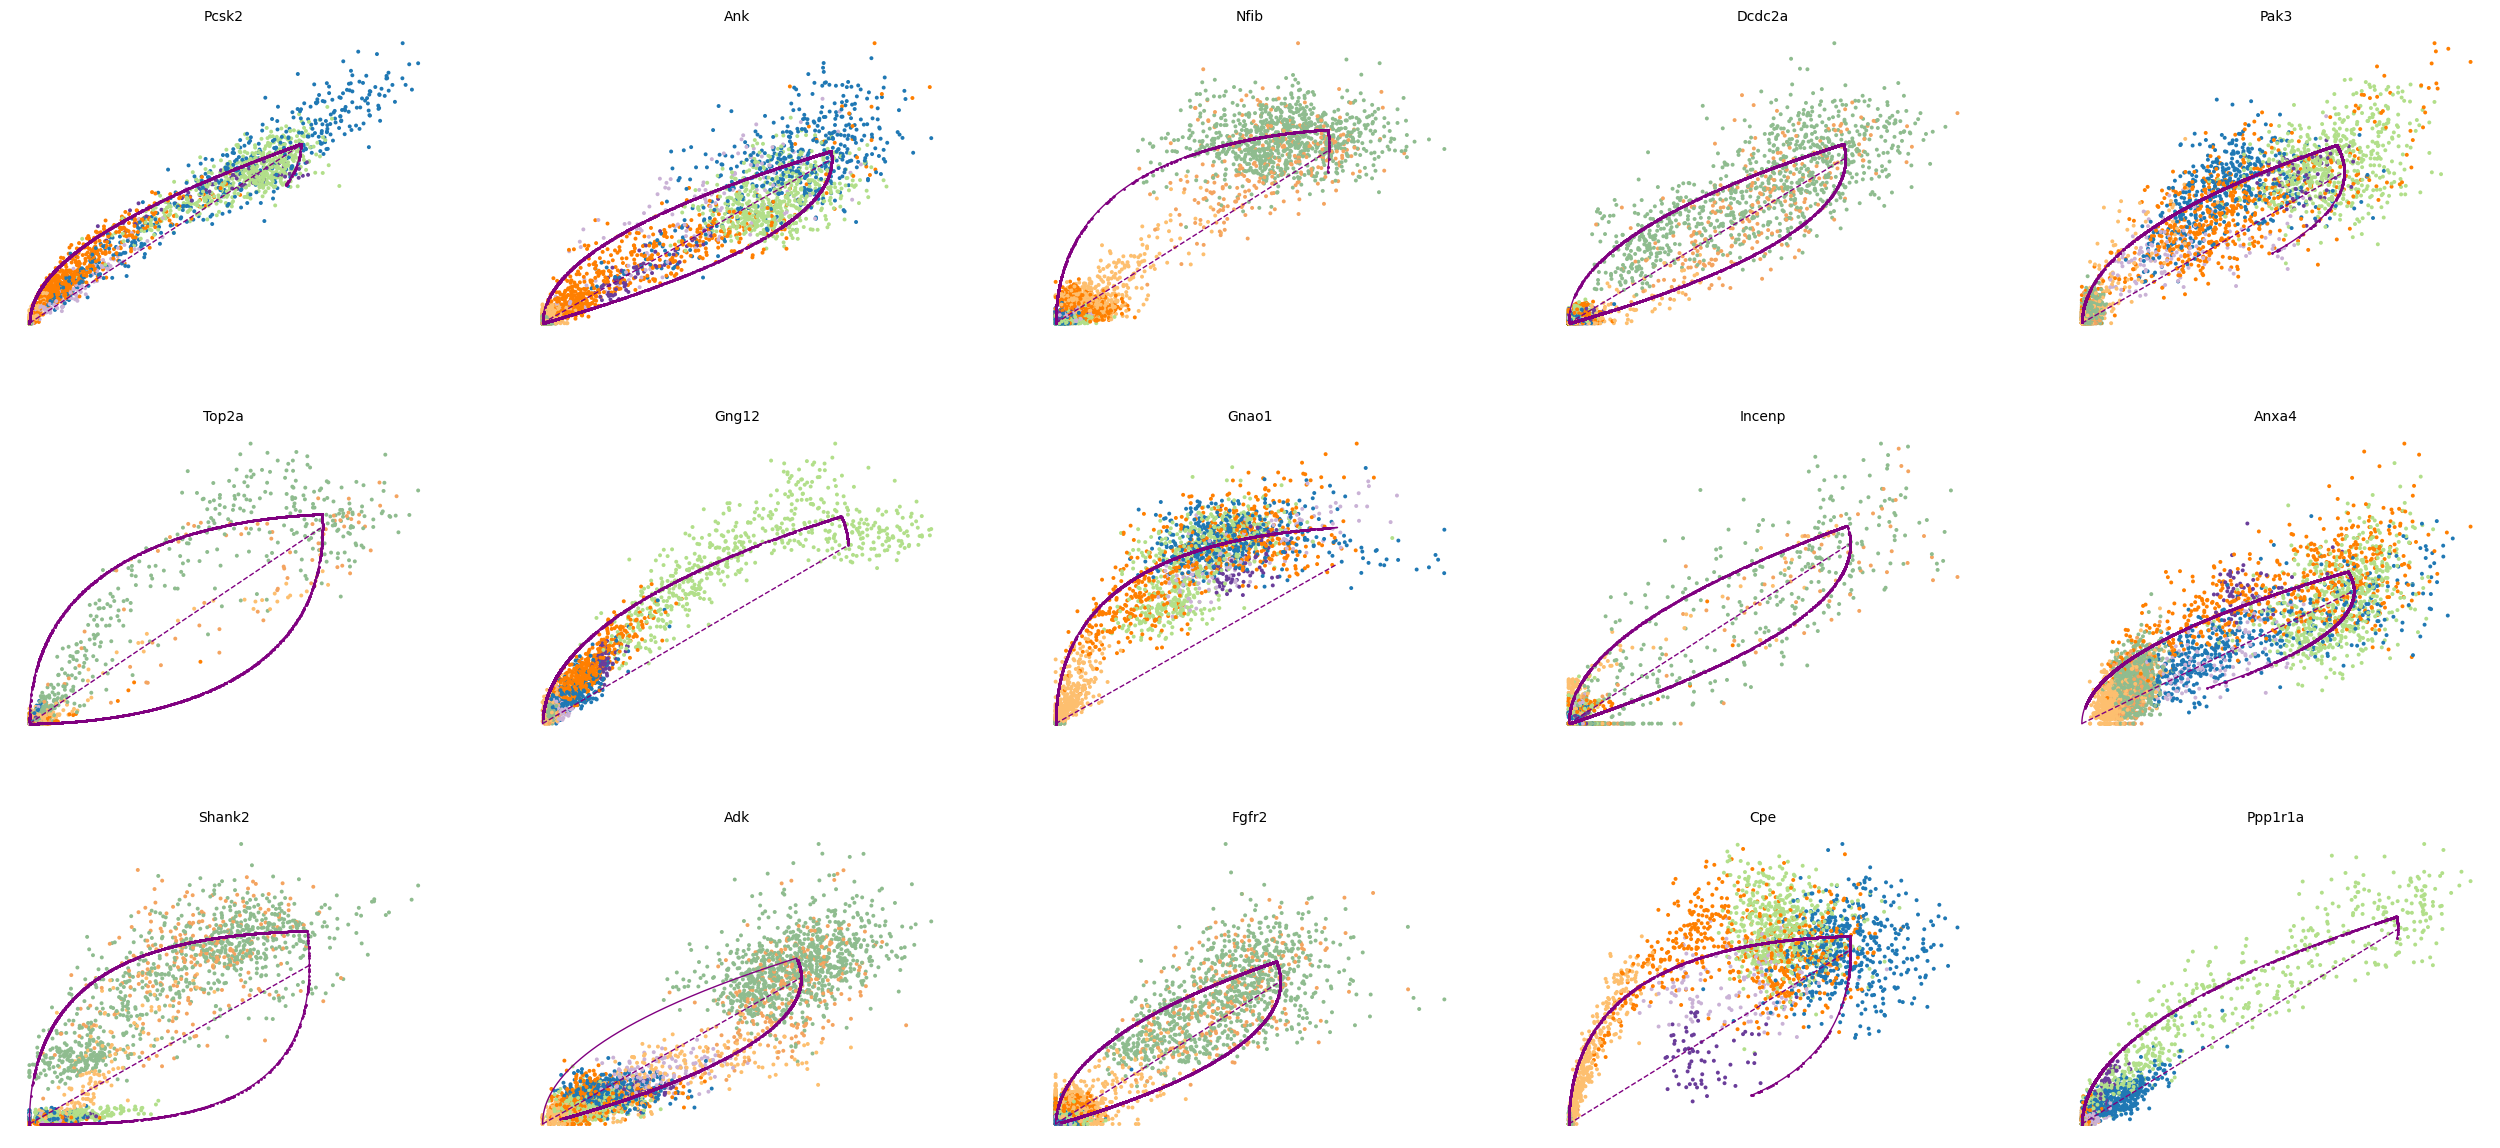

In [22]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

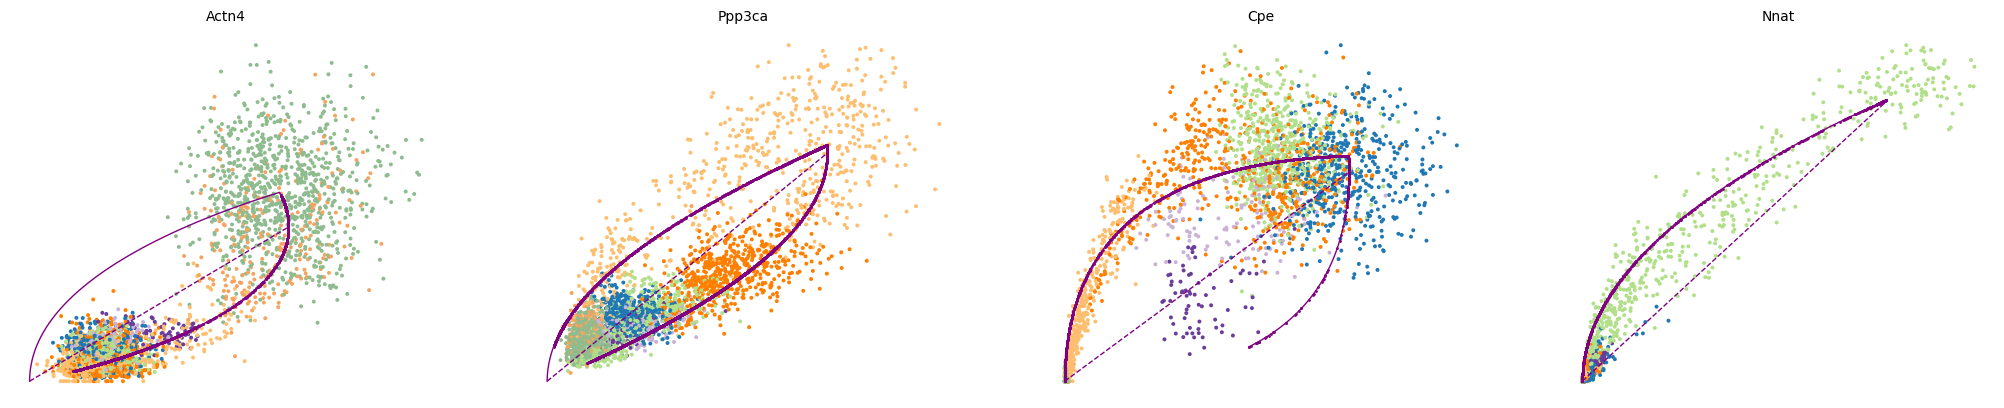

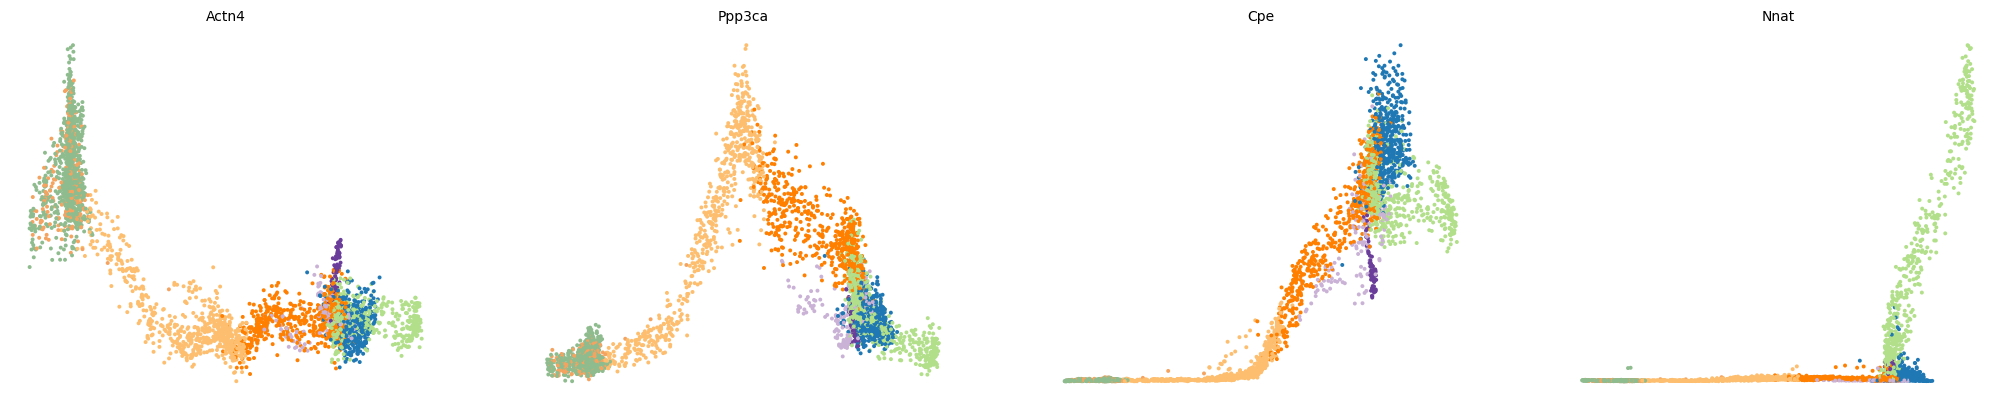

In [23]:
var_names = ['Actn4', 'Ppp3ca', 'Cpe', 'Nnat']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)

In [24]:
scv.tl.rank_dynamical_genes(adata, groupby='clusters')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:03) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine    Beta   Alpha  Delta  \
0    Nfib       Top2a         Gnas         Abcc8   Pcsk2    Pak3  Pcsk2   
1  Dcdc2a      Dcdc2a       Rbfox3        Ppp3ca     Ank   Gnao1   Pak3   
2   Top2a         Adk       Btbd17         Rap1b    Scgn     Cpe  Rap1b   
3  Incenp    Rap1gap2        Tcp11          Gnas  Tspan7  Rph3al  Meis2   
4  Shank2        Tpx2       Mapre3          Tox3   Map1b   Rap1b  Map1b   

  Epsilon  
0    Tox3  
1   Meis2  
2  Rnf130  
3     Adk  
4   Rap1b

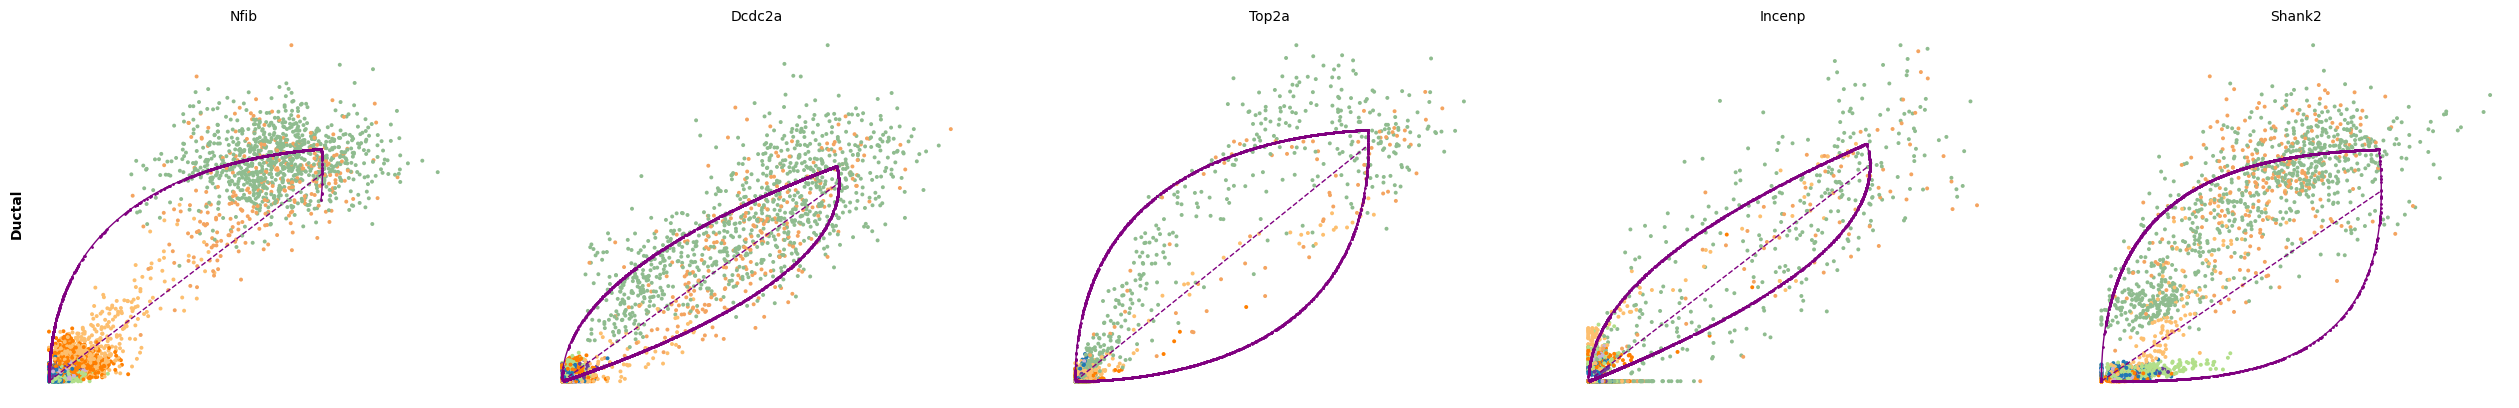

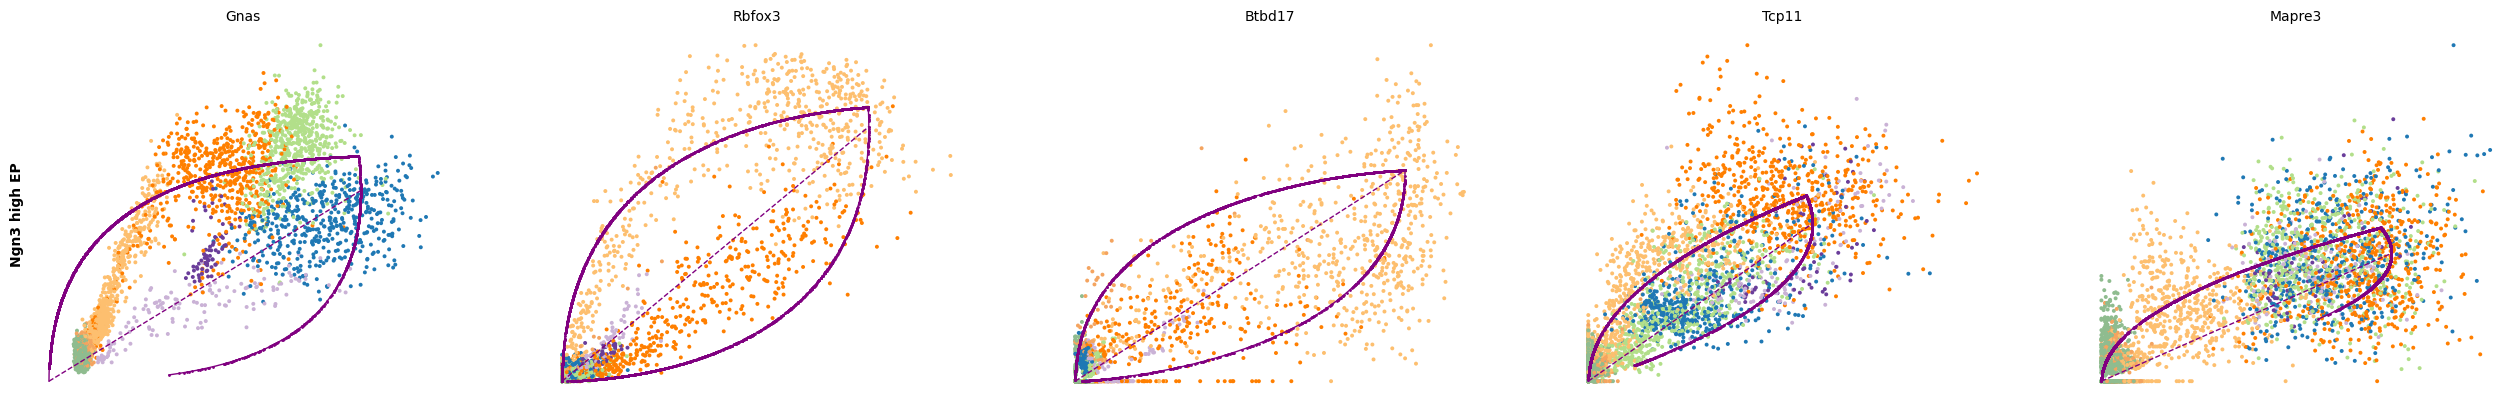

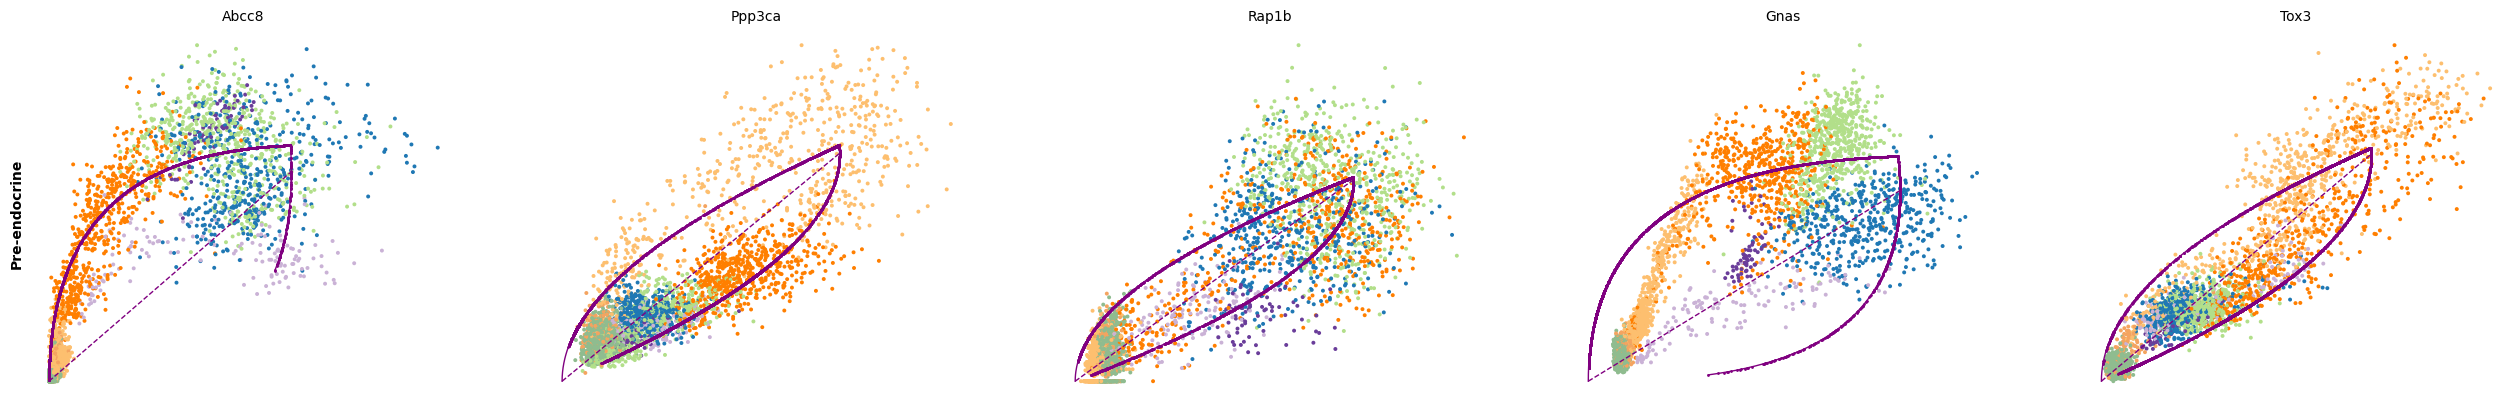

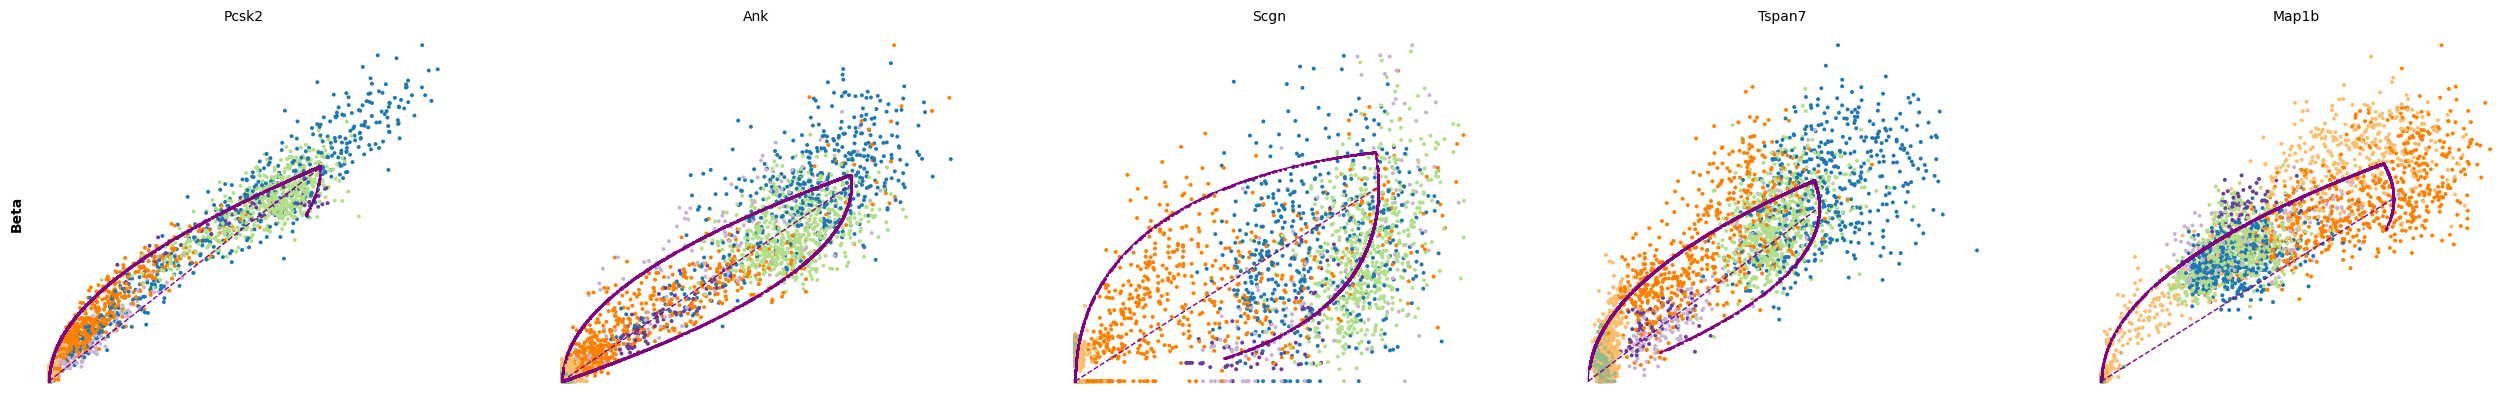

In [25]:
for cluster in ['Ductal', 'Ngn3 high EP', 'Pre-endocrine', 'Beta']:
    scv.pl.scatter(adata, df[cluster][:5], ylabel=cluster, frameon=False)


## Velocities in cycling progenitors

The cell cycle detected by RNA velocity, and it is biologically affirmed by cell cycle scores (standardized scores of mean expression levels of phase marker genes).

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


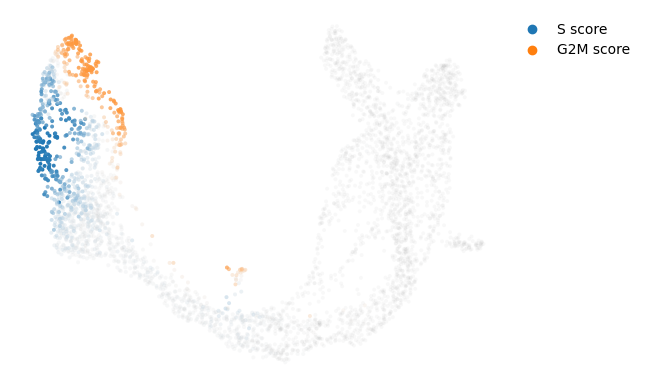

In [26]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

For the cycling Ductal cells, we may screen through S and G2M phase markers. The previous module also computed a spearmans correlation score, which we can use to rank/sort the phase marker genes to then display their phase portraits.

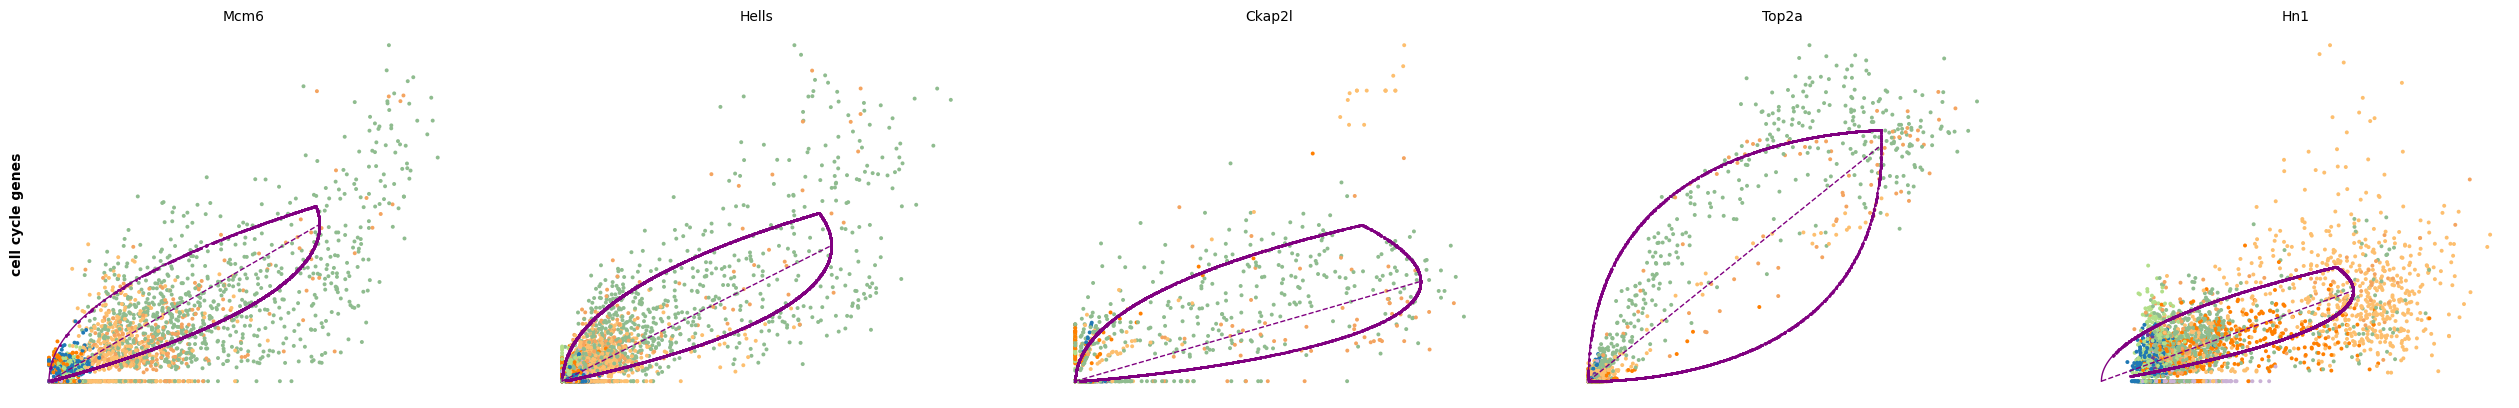

In [27]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)

Particularly Hells and Top2a are well-suited to explain the vector field in the cycling progenitors. Top2a gets assigned a high velocity shortly before it actually peaks in the G2M phase. There, the negative velocity then perfectly matches the immediately following down-regulation.

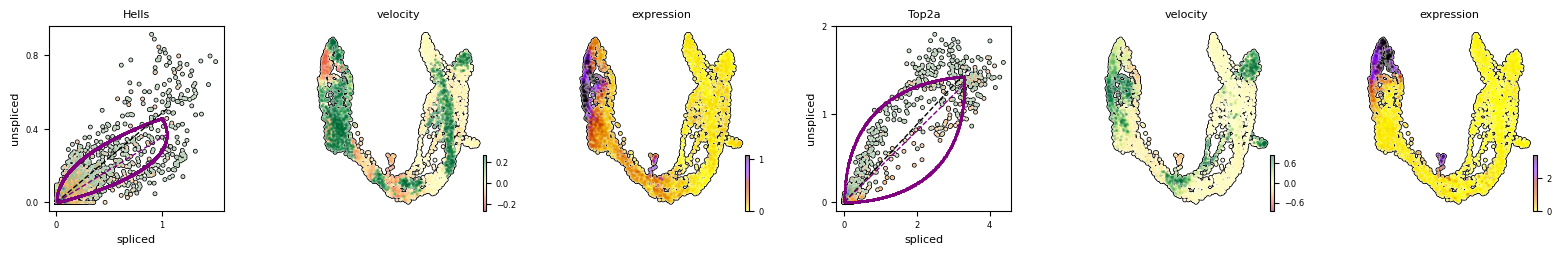

In [28]:
scv.pl.velocity(adata, ['Hells', 'Top2a'], ncols=2, add_outline=True)

The cell cycle is an interesting case for RNA velocity estimation, as pseudotime methods along often fail as estimations of cyclical processes. Moreover, RNA velocity corresponds roughly to cell cycle speed, which is both experimentally verifiable. The cell cycle also unfolds on a timescale of less than 24 hours, which is well suited for studying cell dynamics using RNA lifecycle kinetics, such as with RNA velocity. 